In this notebook, I calculate the normalised residuals of each radio detection relative to the correlation defined by GX 339-4 (without the points with contamination by jet ejecta). 

Assuming:
- y = log10(Lr/Lr0) 
- x = log10(Lx/Lx0)
- $\alpha$, $\beta$, $\sigma$ are from the linreg for GX 339-4.

The the residual for a point (x, y) is: 
- $r =  y - (\beta * x + \alpha)$
- $dr^2  = dy^2 + (\beta^2 * dx^2) + (x^2 * d\beta^2) + d\alpha^2 + \sigma^2$

The normalised residual is:
- $R = r/dr$ 

In [40]:
import numpy as np
np.random.seed(42) # so that the results are reproducible
import matplotlib.pyplot as plt
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath("../0_UTILITY_FUNCTIONS/"))
from get_LrLx_data import *
from outlier_factor import * 
from plotting import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mticker
import textwrap


In [2]:
## From the notebook 4_1_linreg_GX_339.ipynb, I found:
beta = 0.589
dbeta = 0.015
alpha = 0.389
dalpha = 0.052
sigma = 0.08

In [6]:
## Just get the detections
lr0, lx0, lr, dlr, delta_radio, lx, dlx_l, dlx_u, delta_xrays, source_names, unique_names, unique_D, unique_D_prob, t = get_data_arrays(names = None, interp=True, incl_Fr_uplims=False, incl_Fx_uplims=False, type_source=None)

# x:
lx_scaled = lx/lx0
log_lx_scaled = np.log10(lx_scaled) # x
log_dlx_l_scaled = np.log10(lx / (lx - dlx_l)) # = log(lx/lx0) - log( (lx - dlx_l)/ lx0 ) 
log_dlx_u_scaled = np.log10( ( lx + dlx_u) / lx ) # = log( (lx + dlx_u)/ lx0 ) - log(lx/lx0)
log_dlx_scaled = np.maximum(log_dlx_l_scaled , log_dlx_u_scaled )

# y:
lr_scaled = lr/lr0
log_lr_scaled = np.log10(lr_scaled) # y
log_dlr_l_scaled = np.log10(lr / (lr - dlr))
log_dlr_u_scaled = np.log10( ( lr + dlr) / lr )
log_dlr_scaled = np.maximum(log_dlr_l_scaled , log_dlr_u_scaled )

x = log_lx_scaled
y = log_lr_scaled
dx = log_dlx_scaled
dy = log_dlr_scaled

lr0:  4.54e+28
lx0:  5.47e+35

Source names:  ['1A 1744-361', '4U 1543-47', '4U 1630-47', 'Cen X-4', 'Cir X-1', 'EXO 1846-031', 'GRS 1739-278', 'GRS 1915+105', 'GX 339-4', 'H1743-322', 'IGR J17091-3624', 'MAXI J1348-630', 'MAXI J1631-479', 'MAXI J1803-298', 'MAXI J1807+132', 'MAXI J1810-222', 'MAXI J1816-195', 'MAXI J1820+070', 'SAX J1808.4-3658', 'SAX J1810.8-2609', 'Swift J1727.8-1613', 'Swift J1728.9-3613', 'Swift J1842.5-1124', 'Swift J1858.6-0814', 'Vela X-1', 'XTE J1701-462']
Sources included after filtering:  ['4U 1543-47' '4U 1630-47' 'EXO 1846-031' 'GRS 1739-278' 'GX 339-4'
 'H1743-322' 'IGR J17091-3624' 'MAXI J1348-630' 'MAXI J1631-479'
 'MAXI J1803-298' 'MAXI J1810-222' 'MAXI J1816-195' 'MAXI J1820+070'
 'SAX J1808.4-3658' 'SAX J1810.8-2609' 'Swift J1727.8-1613'
 'Swift J1842.5-1124']
Number of source: 17


In [7]:
## Calculate the normalised residuals

# Numerator: residual from the standard track
residuals = y - (beta * x + alpha)

# Denominator: total uncertainty (includes intrinsic scatter, measurement errors, and uncertainties in slope and intercept)
total_var = dy**2 + (beta**2 * dx**2) + (x**2 * dbeta**2) + dalpha**2 + sigma**2
outlier_factor = residuals / np.sqrt(total_var)

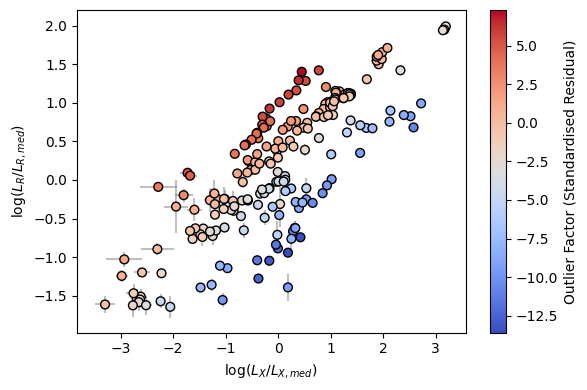

In [12]:
## Plot the results for the normalised residuals

plt.figure(figsize=(6, 4))
sc = plt.scatter(x, y, c=outlier_factor, cmap='coolwarm', s=40, edgecolor='k', zorder=3)
# Then overlay the error bars
plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.', color='gray', alpha=0.5, zorder=1)
# Add a colorbar to show outlier_factor scale
cbar = plt.colorbar(sc)
plt.xlabel(r'$\log(L_X / L_{X,med})$')
plt.ylabel(r'$\log(L_R / L_{R,med})$')
cbar.set_label("Outlier Factor (Standardised Residual)")
plt.tight_layout()
plt.show()

---


# Plots Per Source

In what follows, for the well-sampled sources, I plot histograms of the normalised residuals. I also plot CDFs, as these are not sensitive to binning. 

How to interpret a CDF:
- A CDF answers the question: What fraction of the data is ≤ a given value x?
- Steep rise ⇒ many data points in that region
- Flat region ⇒ few or no data points there
- The median is the value where the CDF = 0.5. 25th percentile: CDF = 0.25. 90th percentile: CDF = 0.90

In [16]:
## Sources to consider

source_list = [
    "GX 339-4",
    "4U 1543-47",
    "H1743-322",
    "MAXI J1348-630",
    "MAXI J1631-479",
    "MAXI J1820+070",
    "SAX J1808.4-3658",
    "Swift J1727.8-1613" 
]

type_sources = ["BH","BH", "BH","BH", "BH", "BH", "NS", "BH"]


###############
## Get D and D_prob for each source
## Parse D_prob to get lower and upper distance bounds for each source 


def get_distance_bounds(prob_entry, min_distance_kpc=1.0):
    """
    Get lower and upper distance bounds from a probability distribution entry
    Calculate 1-sigma bounds for Gaussian probability, or return bounds for uniform probability.

    Parameters:
    - prob_entry: Either Gaussian ("gauss", mu, sigma) or Uniform ("uniform", low, high)
    """
    entry = eval(prob_entry)  # convert string to tuple
    if entry[0] == "gauss":
        mu, sigma = entry[1], entry[2]
        low = max(mu - 1 * sigma, min_distance_kpc)  # clip to physical lower limit
        high = mu + 1 * sigma
        return low, high
    elif entry[0] == "uniform":
        return entry[1], entry[2]
    else:
        raise ValueError("Unknown distribution type.")

D = []
D_prob = []
D_low = []
D_high = []

for name in source_list:
    idx = np.where(unique_names == name)[0][0]  # find index of the source
    D.append(unique_D[idx])
    D_prob_source = unique_D_prob[idx]
    D_prob.append(D_prob_source)
    low, high = get_distance_bounds(D_prob_source)
    D_low.append(low)
    D_high.append(high)
    print(f"{name}: D = {unique_D[idx]}, D_prob = {unique_D_prob[idx]}, D_low = {low}, D_high = {high}")

D = np.array(D)
D_prob = np.array(D_prob)
D_low = np.array(D_low)
D_high = np.array(D_high)

###############
    


GX 339-4: D = 10.0, D_prob = ("uniform", 8, 12), D_low = 8, D_high = 12
4U 1543-47: D = 5.0, D_prob = ("gauss", 5, 1.6), D_low = 3.4, D_high = 6.6
H1743-322: D = 8.5, D_prob = ("gauss", 8.5, 0.8), D_low = 7.7, D_high = 9.3
MAXI J1348-630: D = 2.2, D_prob = ("gauss", 2.2, 0.6), D_low = 1.6, D_high = 2.8000000000000003
MAXI J1631-479: D = 6.5, D_prob = ("uniform", 4.5, 8.5), D_low = 4.5, D_high = 8.5
MAXI J1820+070: D = 2.96, D_prob = ("gauss", 2.96, 0.33), D_low = 2.63, D_high = 3.29
SAX J1808.4-3658: D = 2.7, D_prob = ("uniform", 2.4, 3.6), D_low = 2.4, D_high = 3.6
Swift J1727.8-1613: D = 5.5, D_prob = ('gauss',5.5,1.4), D_low = 4.1, D_high = 6.9


### Show histograms and CDFs

In [54]:
# Bins for histograms
x_range = np.linspace(-15, 8, 500)
bins = np.linspace(-15, 8, 25)


# Plotting parameters
labels = ["Low D", "Best D", "High D"]
colours_D = ["orange", "purple", "green"]
hatches = [ "/", None, "\\"]

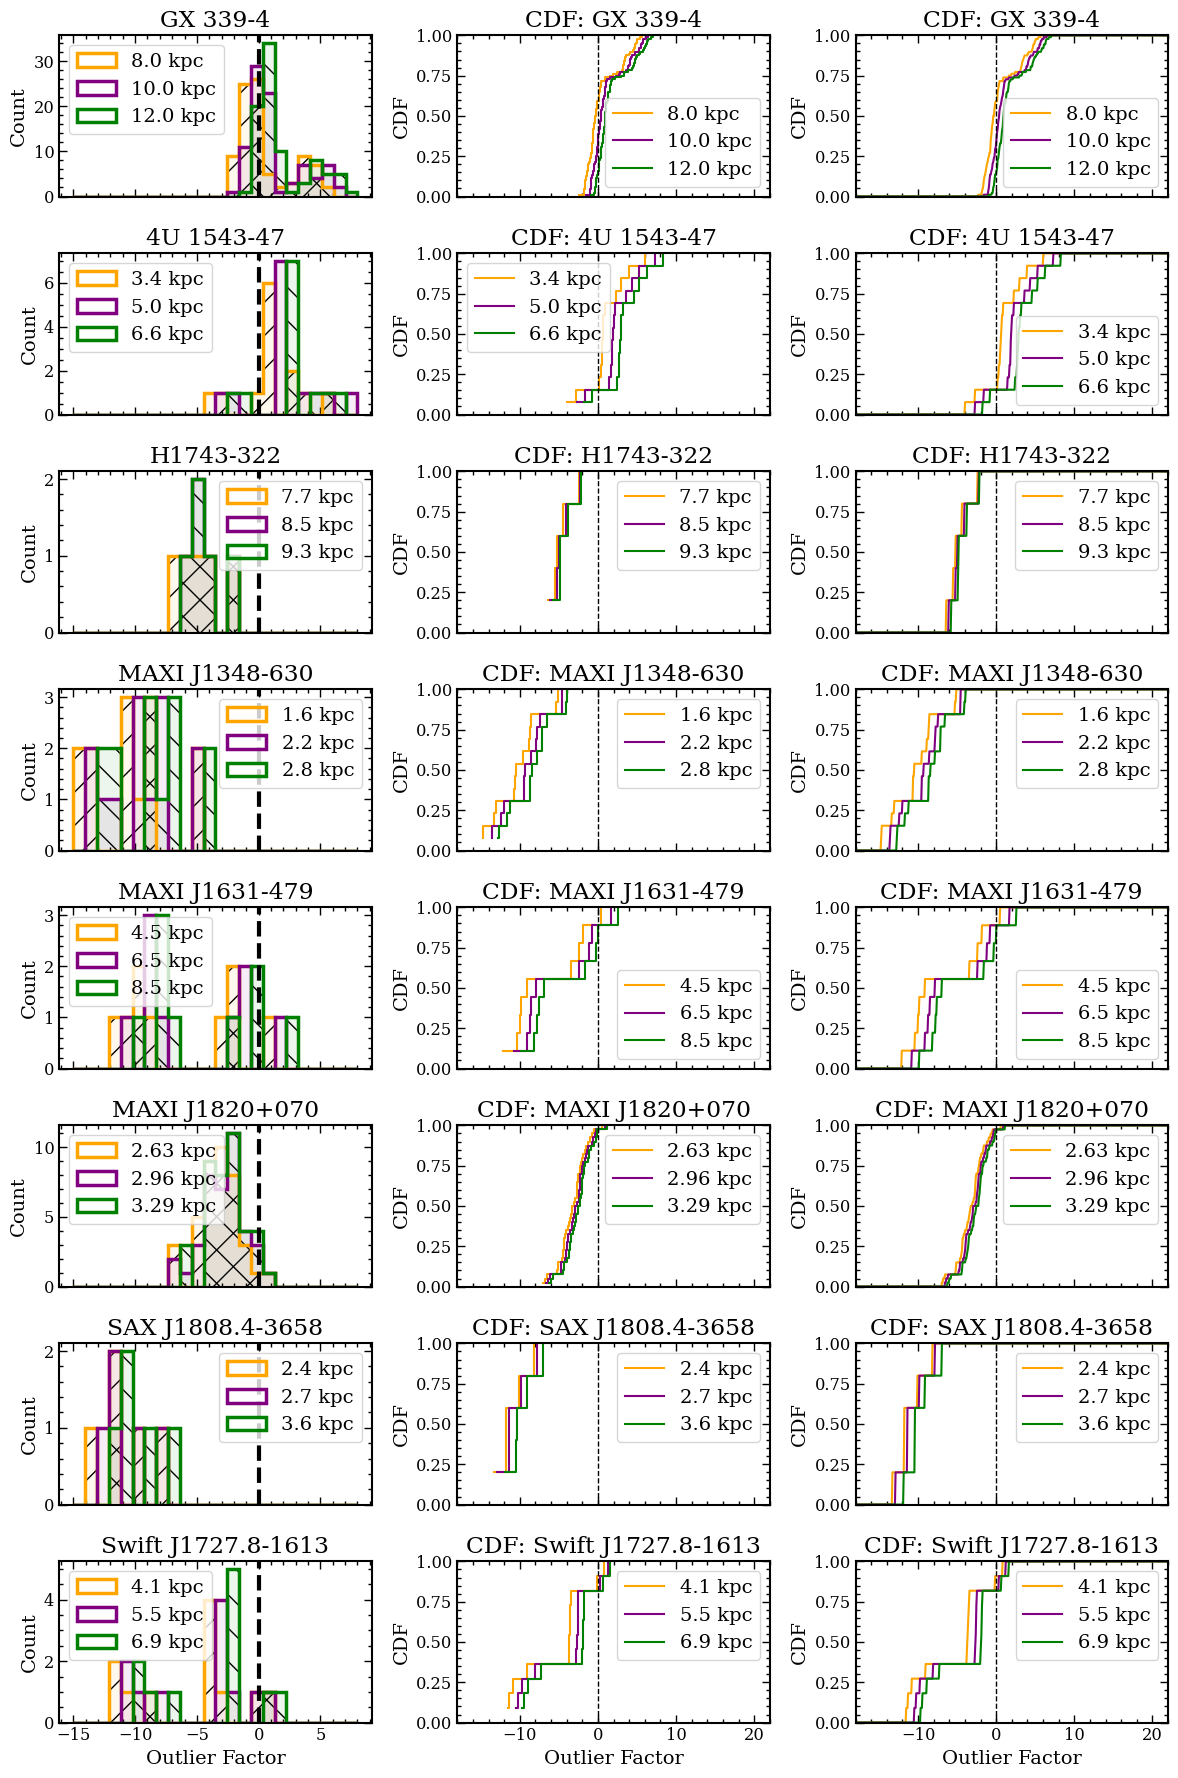

In [57]:
fig, axs = plt.subplots(nrows=len(source_list), ncols=3, figsize=(1.5*len(source_list), 18), sharex='col')


for i, source in enumerate(source_list):

    # Mask data points for this source
    mask = np.array(source_names) == source
    x_vals_orig = x[mask]
    y_vals_orig = y[mask]
    xerr_vals = dx[mask]
    yerr_vals = dy[mask]
    
    for colour, hatch_style, label, D_i in zip(colours_D, hatches, labels, [ D_low[i], D[i], D_high[i]]):

        # Distance correction applied to both x and y values
        correction = 2 * np.log10(D_i / D[i]) # D[i] = D_best
        x_vals = x_vals_orig + correction
        y_vals = y_vals_orig + correction

        # Calculate outlier factor
        residuals = y_vals - (beta * x_vals + alpha)
        total_var = yerr_vals**2 + (beta**2 * xerr_vals**2) + (x_vals**2 * dbeta**2) + dalpha**2 + sigma**2
        of_values = residuals / np.sqrt(total_var)

        # Plot histogram
        axs[i, 0].hist(of_values, bins=bins, histtype='stepfilled', alpha=0.07,  color=colour, hatch=hatch_style, linewidth=1e-5)
        axs[i, 0].hist(of_values, bins=bins, histtype='step', label=f"{np.round(D_i,2)} kpc", edgecolor=colour, linewidth=2.5)


        # Plot CDF -- Way 1
        sorted_of = np.sort(of_values)
        cdf_vals = np.arange(1, len(sorted_of) + 1) / len(sorted_of)
        #axs[i, 1].plot(sorted_of, cdf_vals, label=label)
        lines = axs[i, 1].step(sorted_of, cdf_vals, where='post', label=f"{np.round(D_i,2)} kpc", color=colour)

        # Plot CDF -- Way 2
        cdf_vals = [(of_values <= x).mean() for x in x_range]
        axs[i, 2].plot(x_range, cdf_vals, label=f"{np.round(D_i,2)} kpc", color=colour)
        

    # Format plots
    axs[i, 0].set_title(f"{source}")
    axs[i, 0].set_ylabel("Count")
    axs[i, 0].axvline(0, color='black', linestyle='--', linewidth=3)
    axs[i, 0].legend()

    axs[i, 1].set_title(f"CDF: {source}")
    axs[i, 1].set_ylabel("CDF")
    axs[i, 1].axvline(0, color='black', linestyle='--', linewidth=1)
    axs[i, 1].set_ylim([0,1])
    axs[i, 1].set_xlim([np.min(x_range),np.max(x_range)])
    axs[i, 1].legend()

    axs[i, 2].set_title(f"CDF: {source}")
    axs[i, 2].set_ylabel("CDF")
    axs[i, 2].axvline(0, color='black', linestyle='--', linewidth=1)
    axs[i, 2].set_ylim([0,1])
    axs[i, 2].set_xlim([np.min(x_range),np.max(x_range)])
    axs[i, 2].legend()

# X-axis labels only for the last row
axs[-1, 0].set_xlabel("Outlier Factor")
axs[-1, 1].set_xlabel("Outlier Factor")
axs[-1, 2].set_xlabel("Outlier Factor")

plt.tight_layout()
plt.show()

### Show CDFs with histograms inset

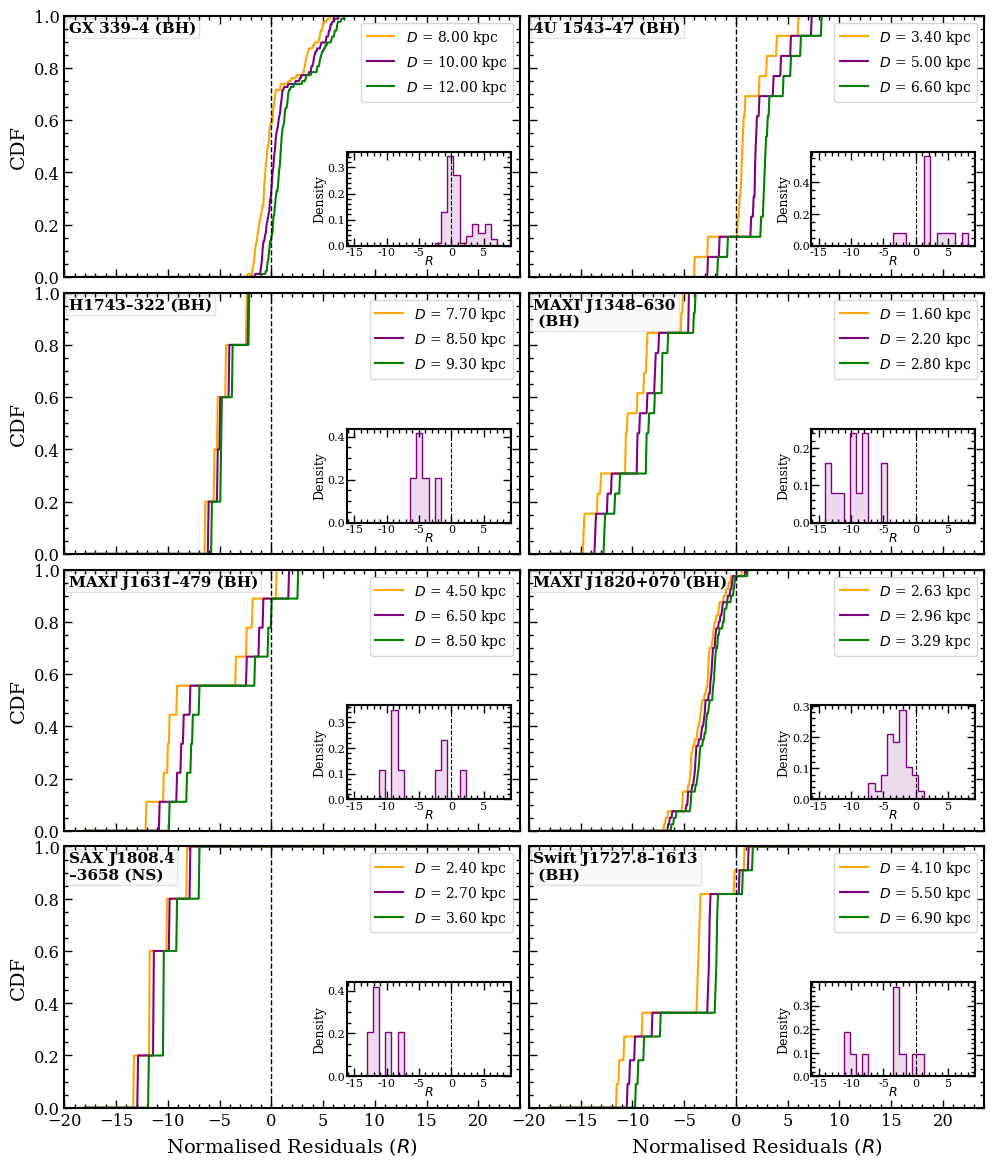

In [58]:
max_chars = 25
x_range = np.linspace(-18, 22, 500)

## Set up the plot
n_sources = len(source_list)
n_cols = 2
n_rows = (n_sources + n_cols - 1) // n_cols
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(10, 3 * n_rows), sharex=True, sharey=True)
axs = axs.flatten()
plt.subplots_adjust(left=0.06, right=0.98, top=0.97, bottom=0.06, hspace=0.06, wspace=0.02)


for i, source in enumerate(source_list):
    
    ax = axs[i]

    ## Create an inset axis 
    # Position: bottom-right with padding to avoid tick overlap
    x0, y0, w, h = 0.38, -0.12, 0.6, 0.6
    inset_ax = inset_axes(ax, width=str(int(w*100)) + "%", height=str(int(h*100)) + "%", bbox_to_anchor=(x0, y0, w, h),bbox_transform=ax.transAxes,borderpad=0.0)


    
    ## Mask data points for this source
    mask = np.array(source_names) == source
    x_vals_orig = x[mask]
    y_vals_orig = y[mask]
    xerr_vals = dx[mask]
    yerr_vals = dy[mask]


    for colour, hatch_style, label, D_i in zip(colours_D, hatches, labels, [ D_low[i], D[i], D_high[i]]):
        
        # Distance correction applied to both x and y values
        correction = 2 * np.log10(D_i / D[i]) # D[i] = D_best
        x_vals = x_vals_orig + correction
        y_vals = y_vals_orig + correction

        # Calculate outlier factor
        residuals = y_vals - (beta * x_vals + alpha)
        total_var = (yerr_vals**2 + (beta**2) * (xerr_vals**2) + (x_vals**2) * (dbeta**2) + dalpha**2 + sigma**2)
        of_values = residuals / np.sqrt(total_var)

        # Plot CDF
        cdf_vals = [(of_values <= x).mean() for x in x_range]
        #label_text = label.replace("D", r"$D$")
        ax.plot(x_range, cdf_vals, label=rf"$D$ = {D_i:.2f} kpc", color=colour)

        # Plot inset CDF for only the best D
        if label == "Best D":
            inset_ax.hist(of_values, bins=bins, density=True, histtype='stepfilled', alpha=0.14, color=colour, edgecolor='none')
            inset_ax.hist(of_values, bins=bins, density=True, histtype='step',color=colour, linewidth=1.0)
            inset_ax.axvline(0, color='k', linestyle='--', linewidth=0.8)
        
    
    ## Plotting style for the main ax
    ax.axvline(0, color='k', linestyle='--', linewidth=1.0)
    ax.set_ylim(0, 1)
    ax.legend(fontsize=10, loc='upper right') 

    if source=="SAX J1808.4-3658": source = "SAX J1808.4\n-3658"
    elif source=="MAXI J1348-630": source = "MAXI J1348-630\n"
    elif source == "Swift J1727.8-1613": source = "Swift J1727.8-1613\n"
    source_text = source.replace("-", "–") 
    label = f"{source_text} ({type_sources[i]})"
    ax.text(0.01, 0.98, label, transform=ax.transAxes,ha='left', va='top',fontsize=11, fontweight='bold', clip_on=False, bbox=dict(facecolor='lightgrey', alpha=0.1, edgecolor='black', pad=2))
    
    # y-labels: only for left-column plots
    if i % n_cols == 0: ax.set_ylabel('CDF')
    # x-labels: only bottom row
    if i >= n_cols * (n_rows - 1): ax.set_xlabel(r'Normalised Residuals ($R$)')

    # Remove unused axes
    for j in range(n_sources, n_rows * n_cols): fig.delaxes(axs[j])
    
    ## Plotting style for the inset
    int_ticks = [-15, -10, -5, 0, 5]
    inset_ax.set_xticks(int_ticks)
    inset_ax.xaxis.set_major_locator(mticker.FixedLocator(int_ticks))
    inset_ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    inset_ax.xaxis.set_label_coords(0.5, -0.09)
    plt.setp(inset_ax.get_xticklabels(), rotation=0, ha='center', fontsize=8)
    inset_ax.tick_params(axis='both', which='major', labelsize=8, pad=1)
    inset_ax.set_xlabel(r'$R$', fontsize=9, labelpad=1)
    inset_ax.set_ylabel('Density', fontsize=9, labelpad=1)
    
    
#plt.tight_layout(pad=0.1, h_pad=0.15, w_pad=0.4)
plt.savefig("../FIGURES/normalised_residuals_cdf_main_inset.png", dpi=300, bbox_inches="tight")
plt.savefig("../FIGURES/normalised_residuals_cdf_main_inset.pdf", dpi=300, bbox_inches="tight")
plt.show()

### CDFs with Monte Carlo distance repeats

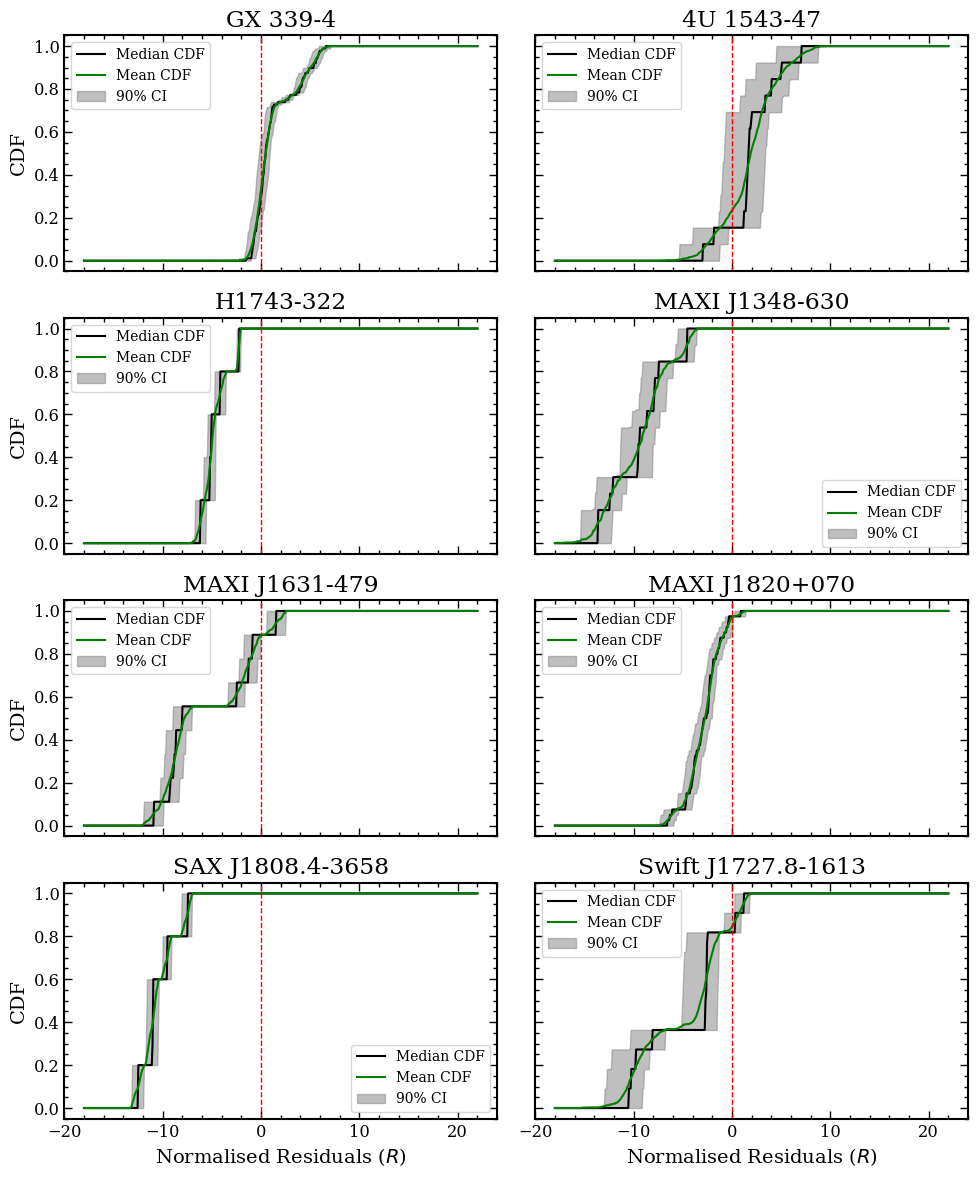

In [63]:
## With MC simulation

from linreg import sample_from_distribution

x_range = np.linspace(-18, 22, 500)
N_runs = 100


## Storage for CDFs
cdf_matrix_per_source = {source: [] for source in source_list}

## Monte Carlo Simulation 
for run in range(N_runs):

    for i, source in enumerate(source_list):
        
        ## Mask for this source's data points
        mask = np.array(source_names) == source
        x_vals_orig = x[mask]
        y_vals_orig = y[mask]
        xerr_vals = dx[mask]
        yerr_vals = dy[mask]

        ## Parse and sample from distance distribution
        dist_type, param1, param2 = eval(D_prob[i]) # string to tuple
        D_sample = sample_from_distribution(dist_type, param1, param2)
        D_best = D[i]

        ## Apply distance correction to x and y
        correction = 2 * np.log10(D_sample / D_best)
        x_vals = x_vals_orig + correction
        y_vals = y_vals_orig + correction

        ## Compute outlier factor
        residuals = y_vals - (beta * x_vals + alpha)
        total_var = yerr_vals**2 + (beta**2 * xerr_vals**2) + (x_vals**2 * dbeta**2) + dalpha**2 + sigma**2
        of_values = residuals / np.sqrt(total_var)

        ## Compute empirical CDF
        # For each x, take the number of values below x and then divides by the number of of_values
        cdf_vals = [(of_values <= x).mean() for x in x_range]
        cdf_matrix_per_source[source].append(cdf_vals)


## Plot CDFs with Uncertainty Bands 
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(10, 3 * n_rows), sharex=True, sharey=True)
axs = axs.flatten()
plt.subplots_adjust(left=0.06, right=0.98, top=0.97, bottom=0.06, hspace=0.06, wspace=0.02)


for i, source in enumerate(source_list):
    cdfs = np.array(cdf_matrix_per_source[source])
    # print(cdfs.shape)  # should be (N_runs, len(x_range))
    median_cdf = np.median(cdfs, axis=0)
    mean_cdf = np.mean(cdfs, axis=0)
    lower_cdf = np.percentile(cdfs, 5, axis=0)
    upper_cdf = np.percentile(cdfs, 95, axis=0)

    # y-labels: only for left-column plots
    if i % n_cols == 0: axs[i].set_ylabel('CDF')
    # x-labels: only bottom row
    if i >= n_cols * (n_rows - 1): axs[i].set_xlabel(r'Normalised Residuals ($R$)')

    axs[i].plot(x_range, median_cdf, color='black', label='Median CDF')
    axs[i].plot(x_range, mean_cdf, color='green', label='Mean CDF')
    axs[i].fill_between(x_range, lower_cdf, upper_cdf, color='gray', alpha=0.5, label='90% CI')
    axs[i].axvline(0, linestyle='--', color='red', linewidth=1)
    axs[i].set_title(f"{source}")
    axs[i].legend(fontsize=10)

plt.tight_layout()
plt.show()